# Summary

This notebook illustrates the idea of modelling oscillatory random number generators. Gaussian Process are used to model phase fluctations and evaluate cryptographic security.   

In [17]:
import numpy as np
!pip install gpflow
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 392.9/392.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 6.8 MB/s eta 0:00:00


# Oscillators

In [76]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

In [120]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, clear_output
import ipywidgets as widgets


class StochasticOscillator:

    def __init__(self, freq=0.2, sigma=0.1):
      self.fig, self.ax = plt.subplots(figsize=(12, 8))
      self.freq = freq
      self.sigma = sigma
      self.N = 10
      self.t = np.linspace(0,self.N,400)
      self.t_sample = np.arange(1/self.freq,self.N+1,1/self.freq)
      y_ref = np.sin(2 * np.pi * self.freq * self.t)
      self.line_ref = self.ax.plot(self.t,y_ref, linestyle='--',label='ideal')[0]
      self.line_perturbed = self.ax.plot([],[],label='noisy')[0]
      self.ax.plot(self.t_sample, np.zeros_like(self.t_sample), 'ro', markersize=6)
      self.bit_text = self.ax.text(0.02, 0.92, '', transform=self.ax.transAxes,
                                        family='monospace', fontweight="bold", fontsize=12)

      self.anim = FuncAnimation(self.fig, self.update, frames=25,interval=200, blit=True)

      # format plots
      self.ax.set_xlim(-0.1, self.N+0.1)
      self.ax.set_ylim(-1.3, 1.3)
      self.ax.set_xlabel('Time (s)')
      self.ax.set_ylabel('Amplitude')
      self.ax.grid(True, alpha=0.3)
      self.ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
      self.ax.legend()

    def update(self, frame):
        # recalculate signals and update plots
        self.noise = np.random.normal(0,1,size=(len(t),)).cumsum() * self.sigma
        self.noise = np.clip(self.noise,a_min=0,a_max=100)
        y_perturbed = np.sin(2 * np.pi * self.freq * self.t + self.noise)
        self.line_perturbed.set_data(self.t, y_perturbed)
        y_perturbed_fn = interpolate.interp1d(self.t, y_perturbed)
        bits = [1 if y_perturbed_fn(t) > 0 else 0 for t in self.t_sample]
        bit_str = ''.join(map(str, bits))
        self.bit_text.set_text(f'Output bits: {bit_str}')
        return self.line_perturbed, self.bit_text

    def display(self):
        """Display the complete widget"""
        # controls = widgets.VBox([self.freq_widget, self.diffusion_widget])
        # display(controls)
        display(HTML(self.anim.to_jshtml()))

# Create and display the oscillator
oscillator = StochasticOscillator(freq=1/3,sigma=0.04)
oscillator.display()

# Samples

0.109544641507272
0.056473169012508685
0.10974453479374635


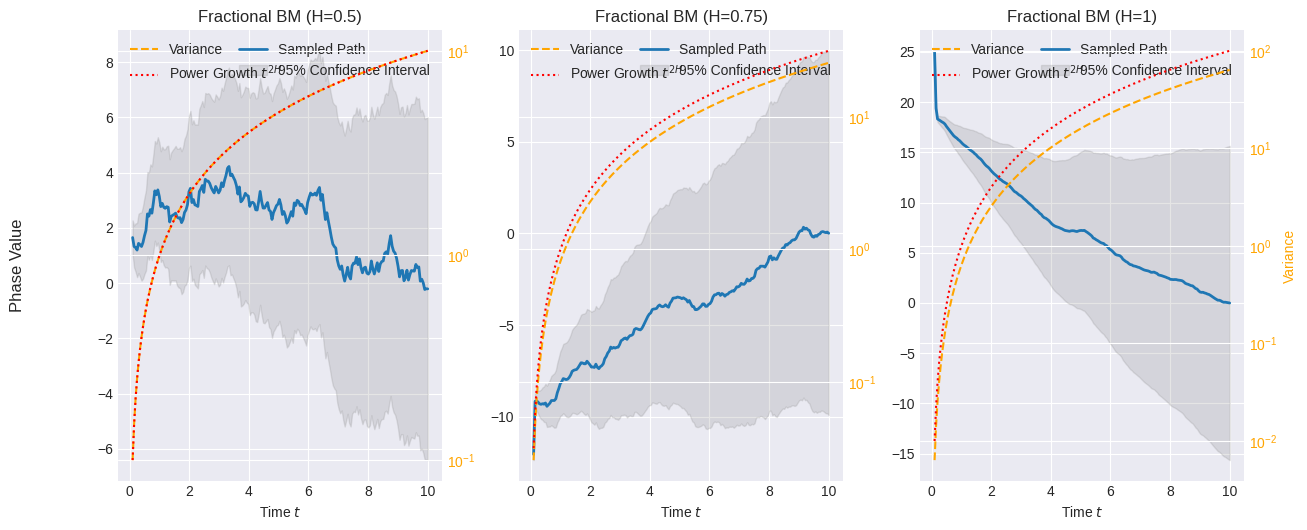

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import hyp2f1, gamma
from scipy.linalg import cholesky
from numpy.random import multivariate_normal

def covariance(t, tau, H):
    """Calculate the covariance for Gaussian processes."""
    term1 = 2 * t**(H + 1/2) * (t + tau)**(H - 1/2)
    hypergeom = hyp2f1(1, 1/2 - H, H + 3/2, t / (t + tau))
    term2 = (gamma(H + 1/2)**2 * (2 * H + 1))
    return term1 * hypergeom / term2

# Parameters
H_vals = [1/2,3/4,1]
num_points = 200  # Number of points to simulate
t_values = np.linspace(0.1, 10, num_points)  # Time points for t
tau_values = np.linspace(0.0, 1.0, 10)  # Variations in tau for covariance matrix

# Plot the sampled paths
fig, axs = plt.subplots(1,len(H_vals),figsize=(14, 6))

for H,ax in zip(H_vals,axs):

    # Construct covariance matrix
    cov_matrix = np.zeros((num_points, num_points))

    # Fill the covariance matrix
    for i in range(num_points):
        for j in range(num_points):
            t = min(t_values[i], t_values[j])
            tau = max(t_values[i], t_values[j]) - t
            cov_matrix[i, j] = covariance(t, tau, H)

    # Sample from the multivariate normal distribution
    mean = np.zeros(num_points)  # Mean vector (zero)
    L = cholesky(cov_matrix + 1e-12 * np.eye(num_points))  # Cholesky decomposition
    y = mean + L @ np.random.normal(size=(num_points,))

    # Plot the sampled paths
    ax.plot(t_values, y, label=f'Sampled Path', lw=2)

    # Calculate the variance curve
    variance = np.diag(cov_matrix)  # Variance along the diagonal of the covariance matrix
    ax2 = ax.twinx()  # Create a secondary axis
    ax2.plot(t_values, variance, color='orange', label='Variance', linestyle='--')
    # ax2.set_ylabel('Variance', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_yscale('log')

    # Plot theoretical power growth
    power_growth = (t_values**(2 * H))  # Power growth of variance
    ax2.plot(t_values, power_growth, color='red', linestyle=':', label='Power Growth $t^{2H}$')
    # ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 1), fontsize=8)

    # # Move legends outside the axes
    # ax2.legend(loc='upper left', bbox_to_anchor=(1.1, 1), fontsize=8)

    # Fill between for 95% Confidence Interval
    ax.fill_between(t_values, y - 1.96 * np.sqrt(variance),
                    y + 1.96 * np.sqrt(variance),
                    color='gray', alpha=0.2, label='95% Confidence Interval')

    ax.set_title(f'Fractional BM (H={H})')
    ax.set_xlabel(r'Time $t$')
    # ax.set_ylabel('Function Value L_H(t)')
    ax.grid(True)

    ax.legend()
    ax2.legend()

    print((np.diff(y,2)**2).mean())


# ax.legend(loc='upper right',bbox_to_anchor=(1.1, 1.1))
ax2.set_ylabel('Variance', color='orange')
ax2.legend(loc='upper right',bbox_to_anchor=(1.1, 1.1))

# for ax in axs:
#     ax.legend()

# Set a common left y-label
fig.supylabel('Phase Value', fontsize=12)
fig.savefig("noise_samples.png")

plt.legend()
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Ensure layout fits well without overlap

plt.show()

# Leakage / Security

We evaluate the variance of the phase at a given location, assuming prior knwoledge of past locations (leakage).

Text(0.5, 1.0, 'Variance Leakage in Flicker Phase Model')

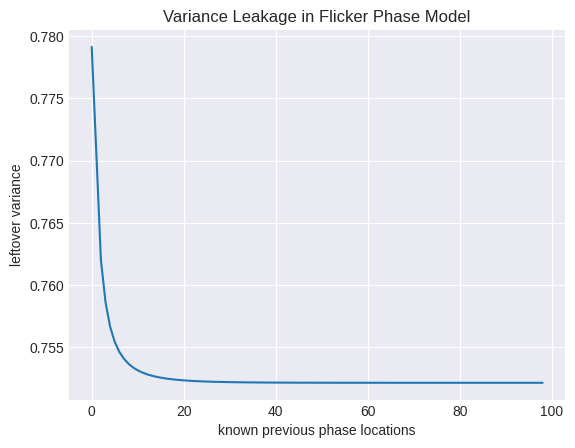

In [18]:
# !python3 -m pip install gpflow --force
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.utilities import positive

class Flicker(gpflow.kernels.Kernel):

    def __init__(self):
        super().__init__(active_dims=[0])
        self.variance = gpflow.Parameter(4/np.pi, transform=positive())

    def K(self, x, y=None):
        if y is None:
            y=tf.transpose(x)
        t = tf.minimum(x,y)
        tau = tf.maximum(x,y)-t
        rho = tau / t
        rho = rho + tf.keras.backend.epsilon()
        cov = tf.square(t) * ( tf.sqrt(rho+1)*(rho+2) - tf.square(rho) * tf.atanh( 1 / tf.sqrt(1+rho ) ) )
        # cov = tf.square(t) *
        cov = 0.25 * cov
        # cov = tf.linalg.set_diag(cov, tf.squeeze(2*tf.square(x)))
        return self.variance * cov

    def K_diag(self, x):
        return self.variance * 0.5 * tf.square( x )


T = 100
h = 1.0

var_leftover = []

k_flicker = Flicker()

for N in range(1,100):
  t = np.linspace(T-N*h,T,N+1).reshape(-1,1)
  s = np.array([T+1.0*h]).reshape(-1,1)

  xx = k_flicker(s)
  yx = k_flicker(t,s)
  yy = k_flicker(t)

  var = xx - tf.transpose(yx) @ tf.linalg.solve(yy,yx) # robust calculations inspired by https://github.com/GPflow/GPflow/blob/862754a07741fe1f08e654fbe62dfd84faa19407/tests/gpflow/covariances/test_base_covariances.py#L100

  var_leftover.append(var.numpy().ravel())

fig, ax = plt.subplots()
plt.plot(np.arange(N),var_leftover)
plt.xlabel("known previous phase locations")
plt.ylabel("leftover variance")
plt.title("Variance Leakage in Flicker Phase Model")
fig.savefig("variance_leakage.png")